In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()

os.chdir( os.path.join('..', 'notebook_format') )
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size
plt.rcParams['font.size'] = 12 # and font size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from scipy.optimize import linear_sum_assignment
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,gensim,scikit-learn,scipy

Ethen 2016-11-05 15:07:44 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
gensim 0.13.1
scikit-learn 0.17.1
scipy 0.18.0


In [3]:
texts = ['human interface computer',
         'survey user computer system response time',
         'eps user interface system',
         'system human system eps',
         'user response time',
         'trees',
         'graph trees',
         'graph minors trees',
         'graph minors survey']

count_vec = CountVectorizer(ngram_range = (1, 2), stop_words = 'english', 
                            min_df = 2, max_df = 0.9, max_features = 10000)

X_dtm = count_vec.fit_transform(texts)
lda = LatentDirichletAllocation(n_topics = 2, max_iter = 10, n_jobs = 1)
doc_topic_distr = lda.fit_transform(X_dtm)

TOPWORDS = 15

def print_top_words(lda_model, vec, n_top_words):
    """top words associated with each topic for the sklearn LDA model"""
    features = vec.get_feature_names()
    for topic_idx, topic in enumerate(lda_model.components_):
        print( 'Topic #{}:'.format(topic_idx) )
        print( ', '.join([ features[i] for i in np.argsort(topic)[-n_top_words:] ]) )
        print()
    
    print()

print_top_words(lda_model = lda, vec = count_vec, n_top_words = TOPWORDS)

Topic #0:
human, interface, eps, computer, minors, response, graph minors, time, user, survey, response time, graph, trees

Topic #1:
response time, time, response, survey, graph minors, trees, minors, graph, user, computer, interface, human, eps




In [4]:
R1 = [
    ['album'],
    ['album', 'music'],
    ['album', 'music', 'best'],
    ['album', 'music', 'best', 'award'],
    ['album', 'music', 'best', 'award', 'win']
]

R2 = [
    ['sport'],
    ['sport', 'best'],
    ['sport', 'best', 'win'],
    ['sport', 'best', 'win', 'medal'],
    ['sport', 'best', 'win', 'medal', 'award']
]

In [5]:
def compute_jaccard(ranking1, ranking2):
    """
    compute jaccard similarity that does not take into account 
    rank positions and indefinite list
    """
    set1 = set(ranking1)
    set2 = set(ranking2)
    
    # if the numerator or the denominator turned out
    # to be 0, return 0 as the jaccard similarity
    numerator = len( set1.intersection(set2) )
    if not numerator:
        return 0

    denominator = len( set1.union(set2) )
    jaccard_sim = numerator / denominator
    return jaccard_sim

In [6]:
def compute_avg_jaccard(ranking1, ranking2):
    """
    weighted version of jaccard similarity, 
    which takes into account rank positions
    """
    total = 0
    k = len(ranking1)
    for i in range(1, k + 1):
        total += compute_jaccard( ranking1[:i], ranking2[:i] )
        
    avg_jaccard_sim = total / k
    return avg_jaccard_sim

In [7]:
ranking1 = R1[4]
ranking2 = R2[4]
compute_jaccard(ranking1, ranking2)
compute_avg_jaccard(ranking1, ranking2)

0.15428571428571428

In [8]:
# compare between two ranking the set
# where the length of the set is simply
# the number of topics in each topic model
S1 = [
    ['sport', 'win', 'award'],
    ['bank', 'finance', 'money'],
    ['music', 'album', 'band']
]

S2 = [
    ['finance', 'bank', 'economy'],
    ['music', 'band', 'award'],
    ['win', 'sport', 'money']
]

In [9]:
n_topic = len(S1)
sim_mat = np.zeros(( n_topic, n_topic ))
for row in range(n_topic):  
    for col in range(n_topic):
        sim_mat[row, col] = compute_avg_jaccard(S1[row], S2[col])

sim_mat

array([[ 0.        ,  0.06666667,  0.5       ],
       [ 0.5       ,  0.        ,  0.06666667],
       [ 0.        ,  0.61111111,  0.        ]])

In [10]:
# solve for the optimal permutation using hungarian algorithm,
# for the scipy implement, each element is presented as cost
# hence we take the negative sign of the similarity matrix
row_ind, col_ind = linear_sum_assignment(-sim_mat)
agreement = np.mean( sim_mat[row_ind, col_ind] )
agreement

0.53703703703703709

In [11]:
def compute_agreement(S1, S2):
    """
    measuring the agreement between two different 
    k-way topic models, represented as two rank sets;
    the rank set is simply the top words for each topic
    """
    
    # compute the similarity matrix
    n_topic = len(S1)
    sim_mat = np.zeros(( n_topic, n_topic ))
    for row in range(n_topic):
        for col in range(n_topic):
            sim_mat[row, col] = compute_avg_jaccard(S1[row], S2[col])    
    
    # solve for the optimal permutation using hungarian algorithm,
    # for the scipy implement, each element is presented as cost
    # hence we use the negative sign of the similarity matrix as input
    row_ind, col_ind = linear_sum_assignment(-sim_mat)
    agreement = np.mean( sim_mat[row_ind, col_ind] )
    return agreement

In [12]:
agreement = compute_agreement(S1, S2)
agreement

0.53703703703703709

- Randomly generate $\gamma$ samples of the dataset, each containing $\beta \times n$ documents ($n$ is simply the total number of documents). 
- For each value of $k \in [kmin, kmax]$:
    - Apply the topic modeling algorithm to the complete data set of $n$ documents to generate $k$ topics, and represent the output as the reference ranking set $S_0$.
    - For each sample $\gamma$:
        - Apply the topic modeling algorithm to it to generate k topics, and represent the output as the ranking set $S_i$. 
        - Calculate the agreement score agree ($S_0$, $S_i$).
    - Compute the mean agreement score for $k$ over all $\gamma$ samples.
- Select one or more values for k based upon the highest mean agreement scores.

When preprocessing the data, terms occurring in < 20 documents were removed, along with English language stop words, but no stemming was performed. Standard log TF-IDF and L2 document length normalization procedures were then applied to the term-document matrix.

we report stability scores for t = 20 (number of top terms used to represent each topic when measuring agreement between ranked lists).

In [13]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_all = fetch_20newsgroups(subset = 'all')

In [14]:
X = np.array(newsgroups_all.data)
n_top_words = 20
n_topics_range = [10, 15, 20, 25]
n_sample_frac = 0.8
n_sample_time = 2

In [15]:
def compute_stability(X, n_topics_range, n_top_words, n_sample_time, n_sample_frac):
    
    topics = len(n_topics_range)
    avg_agreements = np.zeros(topics)
    max_probs = np.zeros(( topics, len(X) ))
    n_sample_size = int(X.shape[0] * n_sample_frac)
    
    for idx, k in enumerate(n_topics_range):
        # we could possibly support different vectorizer and models
        vec = TfidfVectorizer(stop_words = 'english', min_df = 20)
        X_dtm = vec.fit_transform(X)
        features = vec.get_feature_names()
        
        # apply LDA to the complete dataset and 
        # obtain the reference rank set
        lda = LatentDirichletAllocation(n_topics = k, max_iter = 20, 
                                        n_jobs = 1, evaluate_every = 5)
        doc_topic_distr = lda.fit_transform(X_dtm)
        S_reference = get_rank_set(lda, features, n_top_words)
        
        # for each document we'll also store the probability of belonging
        # to the most likely topic (maximum probability), this will be
        # used to visualize the histogram of the max probability later;
        # we'll also normalize the document-topic distribution, because
        # the current verson of the probability is not normalized (0.17)
        doc_topic_distr /= np.sum(doc_topic_distr, axis = 1, keepdims = 1)
        max_probs[idx] = np.max(doc_topic_distr, axis = 1)
        
        # apply LDA to each samples and obtain each samples' rank set
        S_samples = []
        for _ in range(n_sample_time):
            sample = np.random.choice(X, n_sample_size)
            sample_dtm = vec.transform(sample)
            lda.fit(sample_dtm)
            S_sample = get_rank_set(lda, features, n_top_words)
            S_samples.append(S_sample)
        
        # compute average agreement score between reference and samples
        agreements = np.zeros(n_sample_time)
        for s in range(n_sample_time):
            agreements[s] = compute_agreement(S_reference, S_samples[s])

        avg_agreements[idx] = np.mean(agreements)
    
    best_n_topic = n_topics_range[ np.argmax(avg_agreements) ]
    return best_n_topic, avg_agreements, max_probs

In [16]:
def get_rank_set(lda_model, features, n_top_words):
    """
    the rank set for the topic model is simply the top words
    for each topic (a list of list)
    """
    S = []
    for topic in lda_model.components_:
        top_terms = [ features[i] for i in np.argsort(topic)[-n_top_words:] ]
        S.append(top_terms)
        
    return S

In [17]:
best_n_topic, avg_agreements, max_probs = compute_stability(
    X,
    n_topics_range, 
    n_top_words,
    n_sample_time,
    n_sample_frac
)

best_n_topic

15

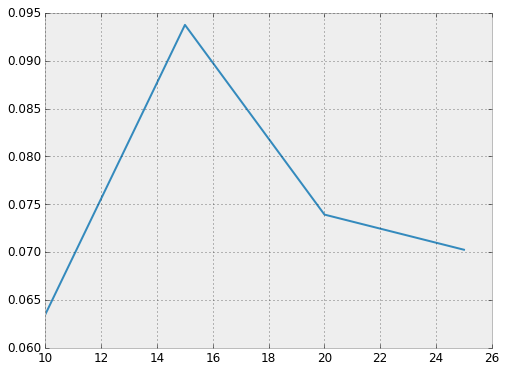

In [19]:
plt.plot(n_topics_range, avg_agreements)
plt.show()

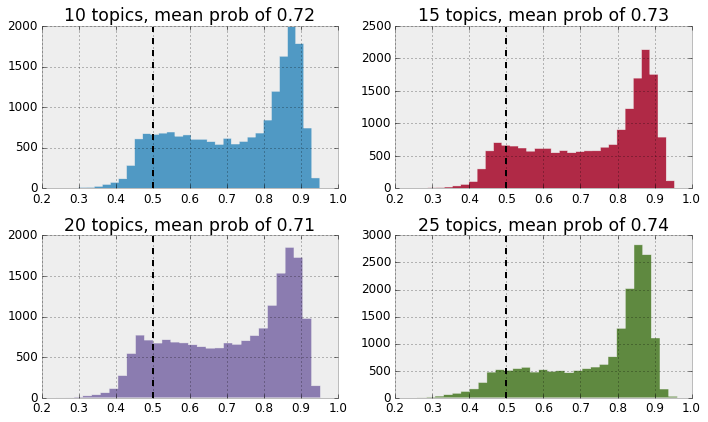

In [21]:
fig = plt.figure(figsize = (10, 6))

# for acessing the color cycle
# http://stackoverflow.com/questions/34247297/matplotlib-1-5-usage-of-axes-prop-cycle
colors = list(plt.rcParams['axes.prop_cycle'])

for k in range( len(n_topics_range) ):    
    plt.subplot(2, 2, k + 1)
    prob = max_probs[k]
    mean_prob = np.round( np.mean(prob), 2 )
    plt.hist( prob, histtype = 'stepfilled', alpha = 0.85, 
              color = colors[k]['color'], bins = 30 )
    plt.title( '{} topics, mean prob of {}'.format( n_topics_range[k], mean_prob ) )
    plt.axvline(x = 0.5, color = "black", linestyle = '--')
    
fig.tight_layout()
fig.show()

## Reference

- [How Many Topics? Stability Analysis for Topic Models (2014) Derek Greene, Derek O'Callaghan, Pádraig Cunningham](https://arxiv.org/abs/1404.4606)